#Importing Dataset and packages

In [1]:
#!pip uninstall scikit-learn
!pip install scikit-learn


In [2]:
!pip install --upgrade scikit-learn -q
!pip install --upgrade -q shap
!pip install pdpbox
import shap
shap.initjs()
from pdpbox import pdp, info_plots

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: sphinx
    Found existing installation: Sphinx 5.0.2
    Uninstalling Sphinx-5.0.2:
      Successfully uninstalled Sphinx-5.0.2


In [3]:
!pip install category_encoders
from category_encoders import TargetEncoder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.4 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
car = pd.read_csv('/content/drive/MyDrive/adverts.csv')

In [7]:
car.head()

public_reference   mileage reg_code standard_colour standard_make  \
0   202006039777689       0.0      NaN            Grey         Volvo   
1   202007020778260  108230.0       61            Blue        Jaguar   
2   202007020778474    7800.0       17            Grey         SKODA   
3   202007080986776   45000.0       16           Brown      Vauxhall   
4   202007161321269   64000.0       64            Grey    Land Rover   

      standard_model vehicle_condition  year_of_registration  price  \
0               XC90               NEW                   NaN  73970   
1                 XF              USED                2011.0   7000   
2               Yeti              USED                2017.0  14000   
3              Mokka              USED                2016.0   7995   
4  Range Rover Sport              USED                2015.0  26995   

   body_type  crossover_car_and_van              fuel_type  
0        SUV                  False  Petrol Plug-in Hybrid  
1     Saloon                  False                 Diesel  
2        SUV                  False                 Petrol  
3  Hatchback                  False                 Diesel  
4        SUV                  False                 Diesel

In [8]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402005 entries, 0 to 402004
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   public_reference       402005 non-null  int64  
 1   mileage                401878 non-null  float64
 2   reg_code               370148 non-null  object 
 3   standard_colour        396627 non-null  object 
 4   standard_make          402005 non-null  object 
 5   standard_model         402005 non-null  object 
 6   vehicle_condition      402005 non-null  object 
 7   year_of_registration   368694 non-null  float64
 8   price                  402005 non-null  int64  
 9   body_type              401168 non-null  object 
 10  crossover_car_and_van  402005 non-null  bool   
 11  fuel_type              401404 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 34.1+ MB


In [9]:
car.shape

(402005, 12)

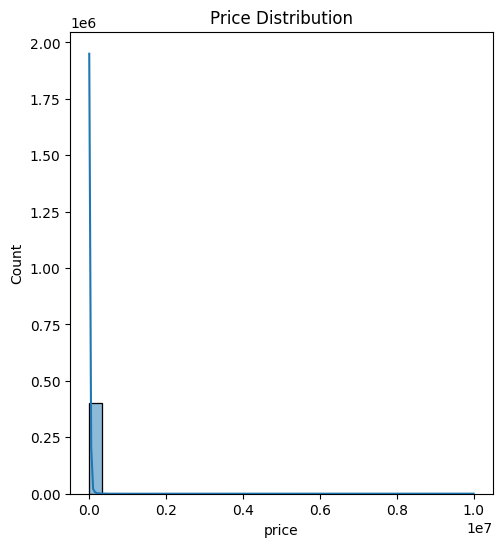

In [128]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(car['price'], bins=30, kde=True)
plt.title('Price Distribution');

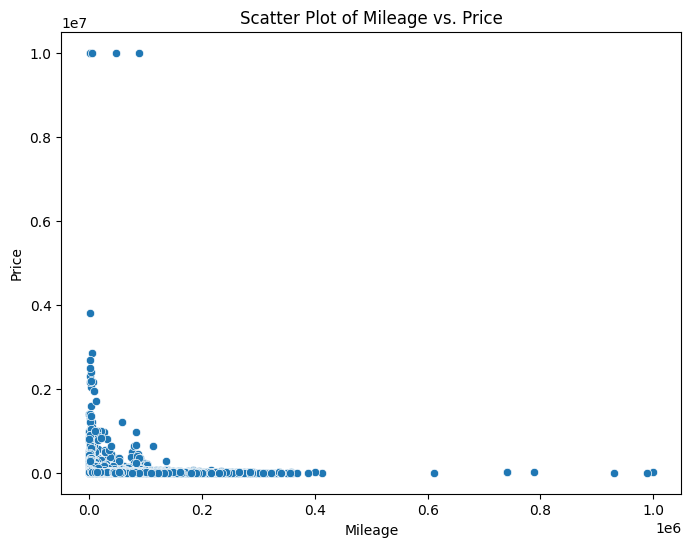

In [10]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=car, x='mileage', y='price')
plt.title('Scatter Plot of Mileage vs. Price')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.show()

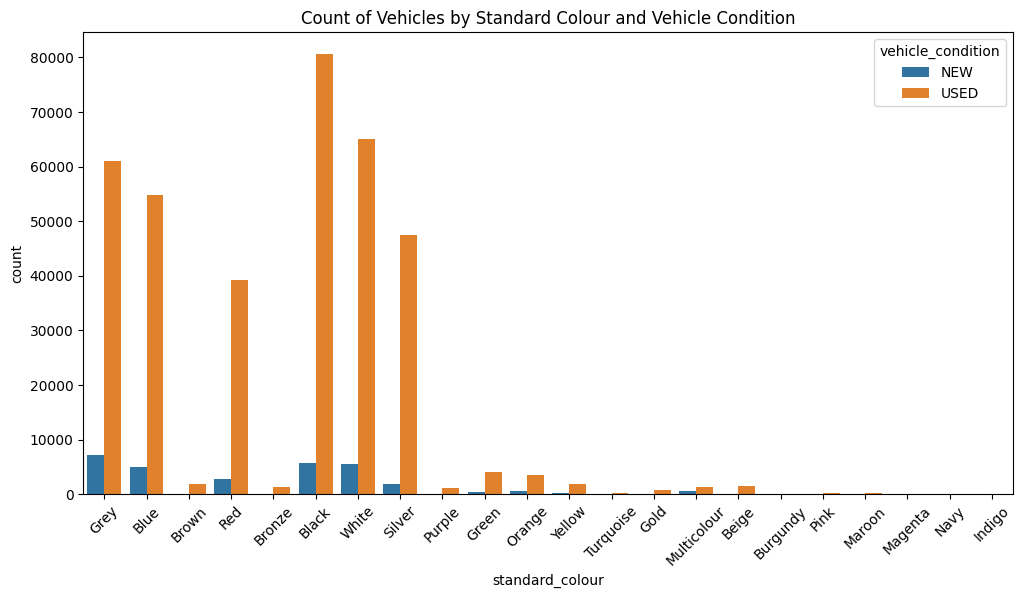

In [129]:
plt.figure(figsize=(12, 6))
sns.countplot(data=car, x='standard_colour', hue='vehicle_condition')
plt.title('Count of Vehicles by Standard Colour and Vehicle Condition')
plt.xticks(rotation=45)
plt.show()

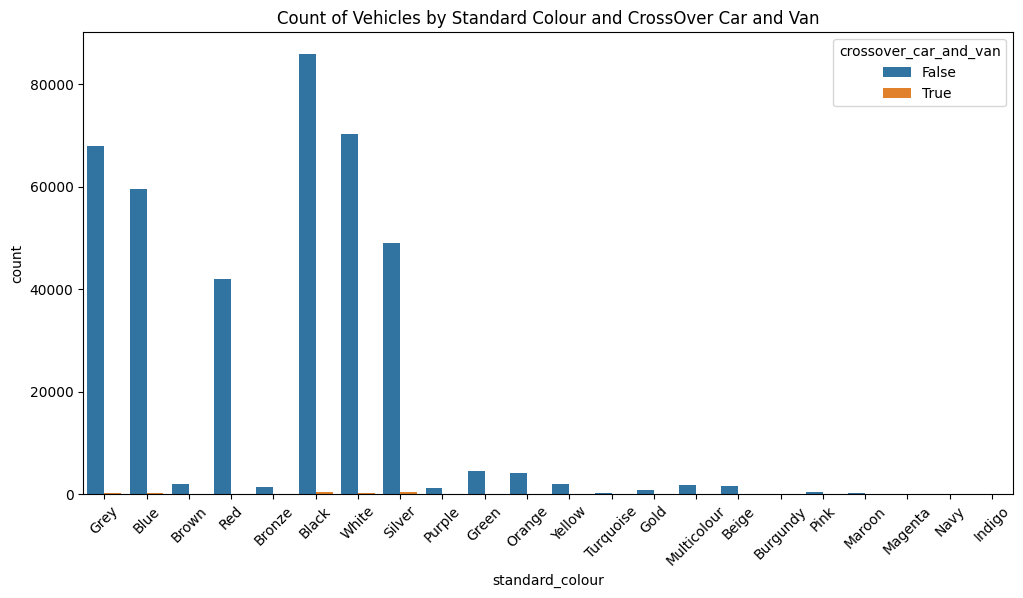

In [11]:
plt.figure(figsize=(12, 6))
sns.countplot(data=car, x='standard_colour', hue='crossover_car_and_van')
plt.title('Count of Vehicles by Standard Colour and CrossOver Car and Van')
plt.xticks(rotation=45)
plt.show()

#Data Preprocessing

In [12]:
# Detect and handle noisy values
car_clean = car[car['mileage'] >= 0]

In [13]:
car_clean.dropna(inplace=True)

In [14]:
from scipy import stats

z_scores = stats.zscore(car_clean['price'])
car_no_outliers = car_clean[(z_scores < 3)]

In [15]:
# Filtering the data outside the given range
car_filtered = car_no_outliers[(car_no_outliers['year_of_registration'] < 1903) |
 (car_no_outliers['year_of_registration'] > 2021)]


In [16]:
car_filtered['year_of_registration'].unique()

array([1007., 1515., 1063., 1009., 1016., 1010., 1008., 1018.,  999.,
       1017., 1006., 1015.])

In [17]:
# Unusual 'year_of_registration' values
unusual_years = [1007., 1515., 1063., 1009., 1016., 1010., 1008., 1018., 999., 1017., 1006., 1015.]

In [18]:
# Filter out rows with unusual 'year_of_registration'
carr = car_no_outliers[~car_no_outliers['year_of_registration'].isin(unusual_years)]

In [19]:
price_99percentile = carr['price'].quantile(0.99)
price_99percentile

57980.0

#Feature Engineering

In [20]:
selected_features = carr[['mileage', 'year_of_registration']]

current_year = 2024
carr['vehicle_age'] = current_year - carr['year_of_registration']

In [21]:
#Transforming existing features
#carr['mileage_per_year'] = carr['mileage'] / carr['vehicle_age']


#carr['price_per_mileage'] = carr['price'] / carr['mileage']

In [22]:
#carr['is_crossover'] = carr['crossover_car_and_van'].apply(lambda x: 1 if x == 'Yes' else 0)

In [23]:
#correlation with heatmap to interpret the relation and multicolliniarity
h=carr.select_dtypes(include='number').corr()

<Axes: >

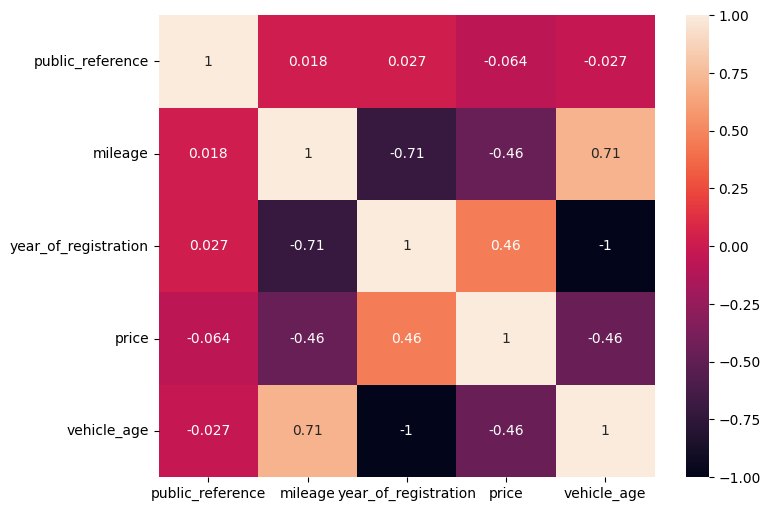

In [24]:
plt.figure(figsize=(8,6))
sns.heatmap(h, annot=True)

In [25]:
carr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 359938 entries, 1 to 402004
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   public_reference       359938 non-null  int64  
 1   mileage                359938 non-null  float64
 2   reg_code               359938 non-null  object 
 3   standard_colour        359938 non-null  object 
 4   standard_make          359938 non-null  object 
 5   standard_model         359938 non-null  object 
 6   vehicle_condition      359938 non-null  object 
 7   year_of_registration   359938 non-null  float64
 8   price                  359938 non-null  int64  
 9   body_type              359938 non-null  object 
 10  crossover_car_and_van  359938 non-null  bool   
 11  fuel_type              359938 non-null  object 
 12  vehicle_age            359938 non-null  float64
dtypes: bool(1), float64(3), int64(2), object(7)
memory usage: 36.0+ MB


In [26]:
from sklearn.preprocessing import TargetEncoder
import category_encoders as ce

cols = ['standard_colour', 'standard_make', 'standard_model', 'vehicle_condition', 'body_type', 'fuel_type']
target = 'price'

for col in cols:  # Added colon here
    te = TargetEncoder()


In [27]:
te = ce.TargetEncoder(cols=cols)

In [28]:
encoded_data = te.fit_transform(carr[cols], carr[target])

In [29]:
car2 = carr.drop(columns=['standard_colour', 'standard_make', 'standard_model', 'vehicle_condition', 'body_type', 'fuel_type'])

In [30]:
car_encoded = pd.concat([car2, encoded_data], axis=1)

In [31]:
car_encoded.shape

(359938, 13)

In [ ]:
#te.fit(X=carr[cols], y=carr[target])

In [ ]:
#encoded_data = te.transform(carr[cols])

In [32]:
#dropping now irrelevant feature
car_encoded.drop(columns=['year_of_registration', 'public_reference', 'crossover_car_and_van', 'reg_code'], inplace=True)

In [33]:
car_encoded.shape

(359938, 9)

In [34]:
car_encoded.head()

mileage  price  vehicle_age  standard_colour  standard_make  \
1  108230.0   7000         13.0     14054.476325   22100.545245   
2    7800.0  14000          7.0     16434.824216   12340.950051   
3   45000.0   7995          8.0     12389.429990    7775.449468   
4   64000.0  26995          9.0     16434.824216   29438.027795   
5   16000.0  29000          7.0     14054.476325   17650.457132   

   standard_model  vehicle_condition     body_type    fuel_type  
1    14696.474576       14259.534073  17005.398007  15196.94796  
2    10570.696233       14259.534073  19328.437335  12668.09338  
3     7832.373860       14259.534073   9653.736966  15196.94796  
4    34525.258025       14259.534073  19328.437335  15196.94796  
5    24115.311594       14259.534073  17118.171149  12668.09338

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(car_encoded[['mileage', 'vehicle_age']])
car_encoded[['mileage', 'vehicle_age']] = scaled_features

In [36]:
#mileage	price	vehicle_age	standard_colour	standard_make	standard_model	vehicle_condition	body_type	fuel_type

#Split data to X and y

In [37]:
X, y = car_encoded.drop(columns='price'), carr['price']

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [39]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.feature_selection import SelectKBest, f_regression, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate



def create_pp_ppln(X, linear_model=False):
    """creates a default preprocessing pipeline for numeric and categorical data
    using simple imputers, scalers, and encoders. It relies on latest versions
    of sklearn so as to produce pandas outputs.

    X: the dataset with the features (needed for feature names)

    returns the Pipeline object
    """

    numeric_features = X.select_dtypes(exclude='object').columns.tolist()
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="mean"))
        ]
    )
    # if we are dealing with a linear model I'll add scaling/polynomial features
    if linear_model:
        numeric_transformer.steps.extend([
            ("scaler", StandardScaler()),
            ('poly', PolynomialFeatures(include_bias=False))
        ])

    categorical_features = X.select_dtypes(include='object').columns.tolist()
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
           # ("enc", TargetEncoder),
              #("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='if_binary')),
            #("feature_selection", SelectFromModel(RandomForestRegressor(), threshold='median')),
        ]
    )


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )

    return preprocessor

def create_regr_ppln(est, X, linear_model=False):
    """ """

    regr_pipe = Pipeline(
        steps=[
            ("pp", create_pp_ppln(X, linear_model)),
            ("feat_sel", SelectKBest(score_func=f_regression, k=8)),
            #("pca", PCA()),
            ("regr", est)
        ]
    )
    regr_pipe['pp'].fit(X)

    check_additivity=False

    return regr_pipe


#Model building and fitting

#Models= Linear Regression, Random Forest, Grandient Boosting

In [40]:
gbr = create_regr_ppln(GradientBoostingRegressor(max_depth=8), X_train)

In [41]:
gbr.fit(X_train, y_train)

Pipeline(steps=[('pp',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['mileage', 'vehicle_age',
                                                   'standard_colour',
                                                   'standard_make',
                                                   'standard_model',
                                                   'vehicle_condition',
                                                   'body_type', 'fuel_type']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  [])],
                                   verbose_feature_names_out=False)),
                ('feat_sel',
                 SelectKBest(k=8,
                             score_func=<function f_regression at 0x793a3b0c0550>)),
                ('regr', GradientBoostingRegressor(max_depth=8))])

In [42]:
eval_results_gbr = cross_validate(
    gbr, X_train, y_train, cv=3,
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    n_jobs=-1
)
print(-eval_results_gbr['test_score'].mean(), eval_results_gbr['test_score'].std())
print(-eval_results_gbr['train_score'].mean(), eval_results_gbr['train_score'].std())

1634.578090691878 5.006622731564635
1542.5471431527794 5.128939307445776


Actual vs Predicted

In [43]:
y_pred_test_gbr = gbr.predict(X_test)
mse_test_gbr = mean_squared_error(y_test, y_pred_test_gbr)
r_squared_test = r2_score(y_test, y_pred_test_gbr)

print(f"Model Metrics:")
print("Test Data:")
print(f"  Mean Squared Error: {mse_test_gbr}")
print(f"  R-squared: {r_squared_test}")

Model Metrics:
Test Data:
  Mean Squared Error: 7199950.305202628
  R-squared: 0.9388692387557784


In [44]:
 # Predict on train data
y_pred_train_gbr = gbr.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train_gbr)
r_squared_train = r2_score(y_train, y_pred_train_gbr)

print(f" Model Metrics:")
print("Train Data:")
print(f"  Mean Squared Error: {mse_train}")
print(f"  R-squared: {r_squared_train}")

 Model Metrics:
Train Data:
  Mean Squared Error: 6094073.6565770665
  R-squared: 0.9496347371584696


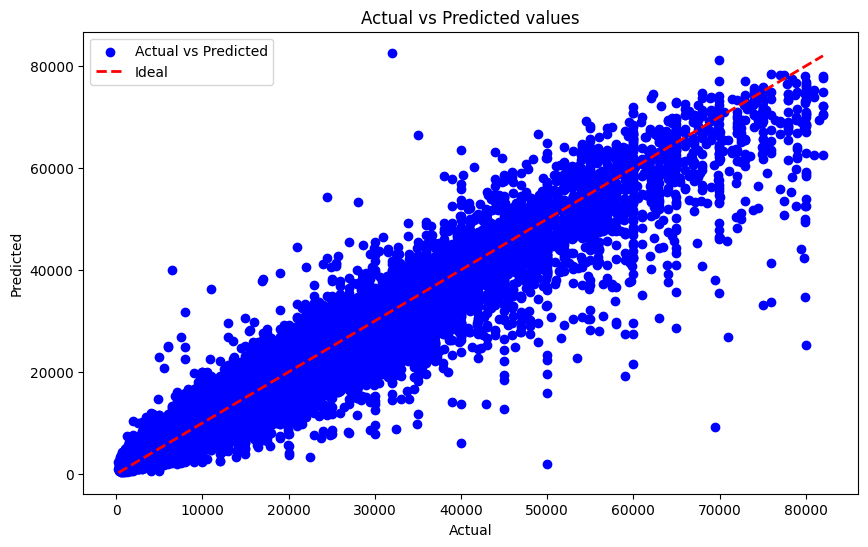

In [45]:
import matplotlib.pyplot as plt

# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test_gbr, color='blue', label='Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red', label='Ideal')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted values')
plt.legend()
plt.show()


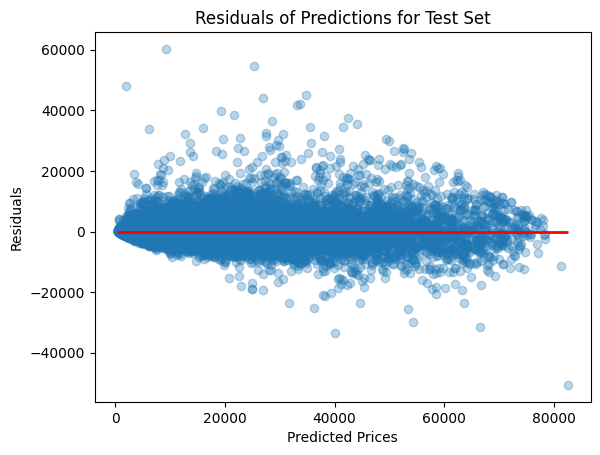

In [46]:
#Residual plot
residuals = y_test - y_pred_test_gbr
plt.scatter(y_pred_test_gbr, residuals, alpha=0.3)
plt.hlines(y=0, xmin=y_pred_test_gbr.min(), xmax=y_pred_test_gbr.max(), colors='red', lw=2)
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residuals of Predictions for Test Set')
plt.show()

#Random Forest

In [47]:
rfr = create_regr_ppln(RandomForestRegressor(max_depth=10), X_train)

In [48]:
rfr.fit(X_train, y_train)

Pipeline(steps=[('pp',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['mileage', 'vehicle_age',
                                                   'standard_colour',
                                                   'standard_make',
                                                   'standard_model',
                                                   'vehicle_condition',
                                                   'body_type', 'fuel_type']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  [])],
                                   verbose_feature_names_out=False)),
                ('feat_sel',
                 SelectKBest(k=8,
                             score_func=<function f_regression at 0x793a3b0c0550>)),
                ('regr', RandomForestRegressor(max_depth=10))])

In [49]:
eval_results_rfr = cross_validate(
    rfr, X_train, y_train, cv=3,
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    n_jobs=-1
)
print(-eval_results_rfr['test_score'].mean(), eval_results_rfr['test_score'].std())
print(-eval_results_rfr['train_score'].mean(), eval_results_rfr['train_score'].std())


1985.1525970647574 10.971994901898507
1926.6262365945258 9.320103089595325


Actual vs Predicted

In [ ]:
y_pred_test_rf = rfr.predict(X_test)
mse_test_rf = mean_squared_error(y_test, y_pred_test_rf)
r_squared_test = r2_score(y_test, y_pred_test_rf)

print(f"Model Metrics:")
print("Test Data:")
print(f"  Mean Squared Error: {mse_test_rf}")
print(f"  R-squared: {r_squared_test}")

In [51]:
y_pred_train_rf = rfr.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train_rf)
r_squared_train = r2_score(y_train, y_pred_train_rf)

print(f" Model Metrics:")
print("Train Data:")
print(f"  Mean Squared Error: {mse_train}")
print(f"  R-squared: {r_squared_train}")

 Model Metrics:
Train Data:
  Mean Squared Error: 9722087.164869532
  R-squared: 0.9196505485458878


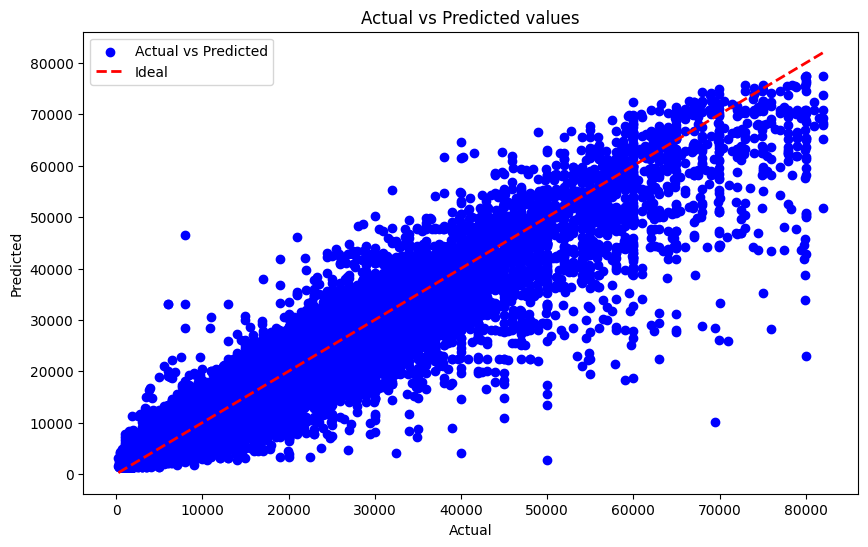

In [52]:
# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test_rf, color='blue', label='Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red', label='Ideal')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted values')
plt.legend()
plt.show()


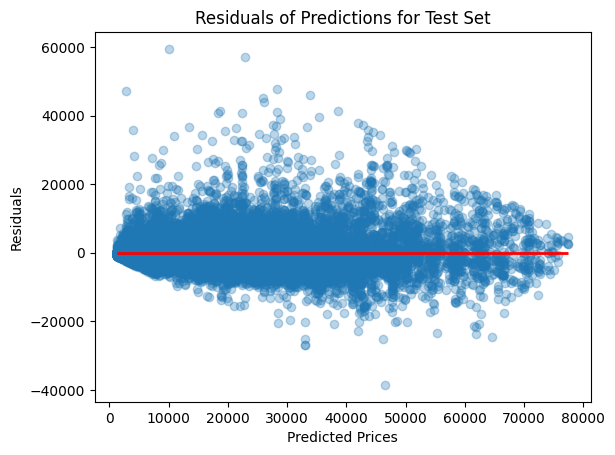

In [53]:
#Residual plot
residuals = y_test - y_pred_test_rf
plt.scatter(y_pred_test_rf, residuals, alpha=0.3)
plt.hlines(y=0, xmin=y_pred_test_rf.min(), xmax=y_pred_test_rf.max(), colors='red', lw=2)
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residuals of Predictions for Test Set')
plt.show()

#Linear Model

In [54]:
lr = create_regr_ppln(LinearRegression(), X_train, linear_model=True)

In [55]:
lr.fit(X_train, y_train)

Pipeline(steps=[('pp',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['mileage', 'vehicle_age',
                                                   'standard_colour',
                                                   'standard_make',
                                                   'standard_model',
                                                   'vehicle_condition',
                                                   'body_type', 'fuel_type']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  [])],
                                   verbose_feature_names_out=False)),
                ('feat_sel',
                 SelectKBest(k=8,
                             score_func=<function f_regression at 0x793a3b0c0550>)),
                ('regr', LinearRegression())])

In [56]:
eval_results_lr = cross_validate(
    lr, X_train, y_train, cv=3,
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    n_jobs=-1
)
print(-eval_results_lr['test_score'].mean(), eval_results_lr['test_score'].std())
print(-eval_results_lr['train_score'].mean(), eval_results_lr['train_score'].std())


3369.4187313766543 6.862384948155483
3369.313957223914 2.8821239169660413


Actual vs Predicted

In [57]:
y_pred_test_lr = lr.predict(X_test)
mse_test_lr = mean_squared_error(y_test, y_pred_test_lr)
r_squared_test = r2_score(y_test, y_pred_test_lr)

print(f"Model Metrics:")
print("Test Data:")
print(f"  Mean Squared Error: {mse_test_lr}")
print(f"  R-squared: {r_squared_test}")

Model Metrics:
Test Data:
  Mean Squared Error: 27231907.777475815
  R-squared: 0.7687890635346982


In [58]:
# Predict on train data
y_pred_train_lr = lr.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train_lr)
r_squared_train = r2_score(y_train, y_pred_train_lr)

print(f" Model Metrics:")
print("Train Data:")
print(f"  Mean Squared Error: {mse_train}")
print(f"  R-squared: {r_squared_train}")

 Model Metrics:
Train Data:
  Mean Squared Error: 27438959.967460494
  R-squared: 0.7732271533397239


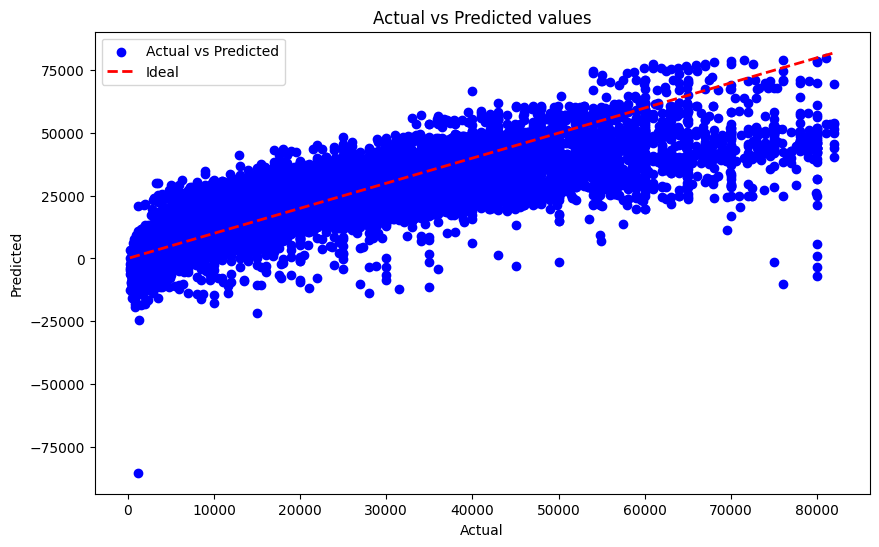

In [59]:
# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test_lr, color='blue', label='Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red', label='Ideal')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted values')
plt.legend()
plt.show()


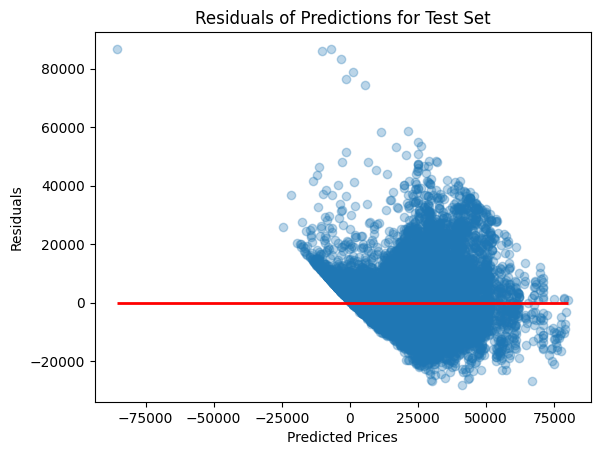

In [60]:
#Residual plot
residuals = y_test - y_pred_test_lr
plt.scatter(y_pred_test_lr, residuals, alpha=0.3)
plt.hlines(y=0, xmin=y_pred_test_lr.min(), xmax=y_pred_test_lr.max(), colors='red', lw=2)
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residuals of Predictions for Test Set')
plt.show()

#Ensemble

In [61]:
my_models = [gbr, rfr, lr]

In [62]:
for est in my_models:
    est.fit(X_train, y_train)

In [63]:
model_results_list = []
for my_model in [gbr, rfr, lr]:
    eval_results = cross_validate(
        my_model, X_train, y_train, cv=3,
        scoring='neg_mean_absolute_error',
        return_train_score=True,
        n_jobs=-1
    )
    model_results_list.append(
        (-eval_results['test_score'].mean(), eval_results['test_score'].std(),
         -eval_results['train_score'].mean(), eval_results['train_score'].std())
    )

In [64]:
model_results = pd.DataFrame(
    model_results_list,
    columns=['test_mae_mean', 'test_mae_std', 'train_mae_mean', 'train_mae_std'],
    index=['gbr', 'rfr', 'lr']
)

In [ ]:
model_results

test_mae_mean  test_mae_std  train_mae_mean  train_mae_std
gbr    1634.553933      5.101639     1542.546743       5.129494
rfr    1985.175169     11.028063     1926.566156       9.478154
lr     3369.418731      6.862385     3369.313957       2.882124

In [65]:
ensemble = VotingRegressor(
    [
        ("gb", gbr),
        ("rf", rfr),
        ('lr', lr)
    ]
)
ensemble.fit(X_train, y_train)

VotingRegressor(estimators=[('gb',
                             Pipeline(steps=[('pp',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer())]),
                                                                               ['mileage',
                                                                                'vehicle_age',
                                                                                'standard_colour',
                                                                                'standard_make',
                                                                                'standard_model',
                                                                                'vehicle_condition',
                                                                                'body_type',
                                                                                'fuel_type']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_...
                                                                               ['mileage',
                                                                                'vehicle_age',
                                                                                'standard_colour',
                                                                                'standard_make',
                                                                                'standard_model',
                                                                                'vehicle_condition',
                                                                                'body_type',
                                                                                'fuel_type']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent'))]),
                                                                               [])],
                                                                verbose_feature_names_out=False)),
                                             ('feat_sel',
                                              SelectKBest(k=8,
                                                          score_func=<function f_regression at 0x793a3b0c0550>)),
                                             ('regr', LinearRegression())]))])

In [66]:
eval_results = cross_validate(
    ensemble, X_train, y_train, cv=3,
    scoring='neg_mean_absolute_error',
    return_train_score=True
)
ensemble_result = (
    -eval_results['test_score'].mean(), eval_results['test_score'].std(),
    -eval_results['train_score'].mean(), eval_results['train_score'].std()
)
print(-eval_results['test_score'].mean(), eval_results['test_score'].std())
print(-eval_results['train_score'].mean(), eval_results['train_score'].std())

2077.8733741245383 4.0553091015190255
2036.9873096650774 1.5561106288790347


In [67]:
model_results.loc['ensemble'] = ensemble_result

In [68]:
model_results

test_mae_mean  test_mae_std  train_mae_mean  train_mae_std
gbr         1634.709037      5.174086     1542.547143       5.128939
rfr         1985.166919      8.366046     1926.004677       7.370065
lr          3369.418731      6.862385     3369.313957       2.882124
ensemble    2077.873374      4.055309     2036.987310       1.556111

Actual vs Predicted

In [69]:
y_pred_ensemble = ensemble.predict(X_test)
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
r_squared_ensemble = r2_score(y_test, y_pred_ensemble)

print("Ensemble Model Metrics:")
print(f"Mean Squared Error: {mse_ensemble}")
print(f"R-squared: {r_squared_ensemble}")


Ensemble Model Metrics:
Mean Squared Error: 10884419.772105616
R-squared: 0.9075864640496644


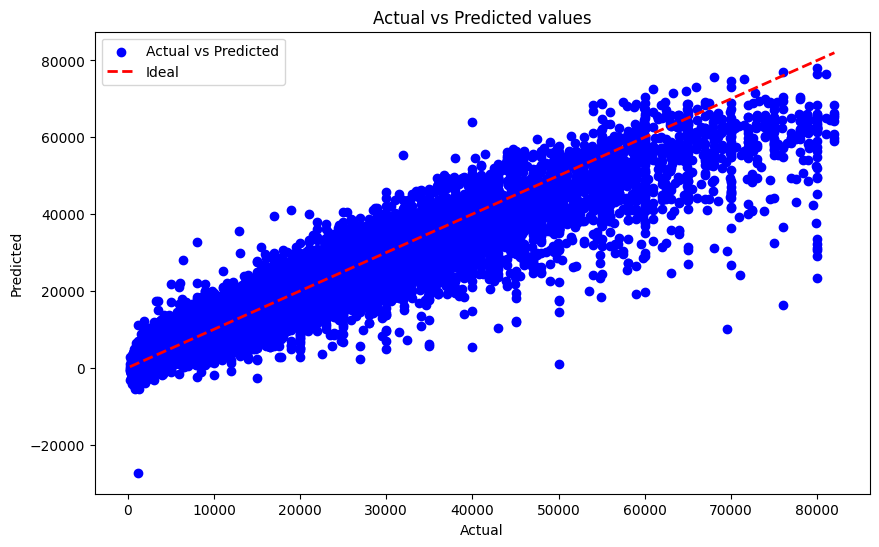

In [70]:
# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_ensemble, color='blue', label='Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red', label='Ideal')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted values')
plt.legend()
plt.show()

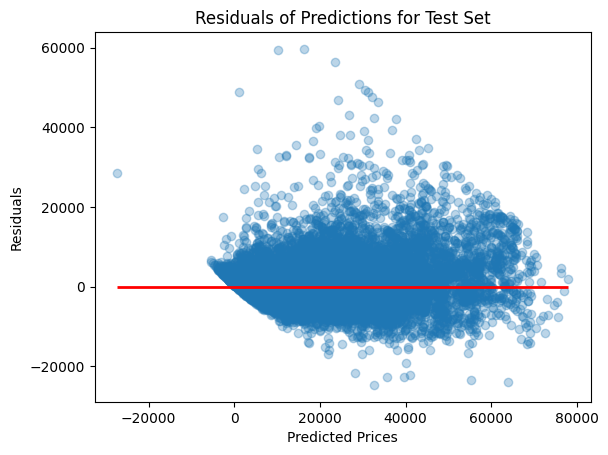

In [71]:
# Residuals Plot
residuals = y_test - y_pred_ensemble
plt.scatter(y_pred_ensemble, residuals, alpha=0.3)
plt.hlines(y=0, xmin=y_pred_ensemble.min(), xmax=y_pred_ensemble.max(), colors='red', lw=2)
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residuals of Predictions for Test Set')
plt.show()

In [72]:
xt = X.head(10)
yt = y.head(10)
gbr_pred = gbr.predict(xt)
rfr_pred = rfr.predict(xt)
lr_pred = lr.predict(xt)
ens_pred = ensemble.predict(xt)

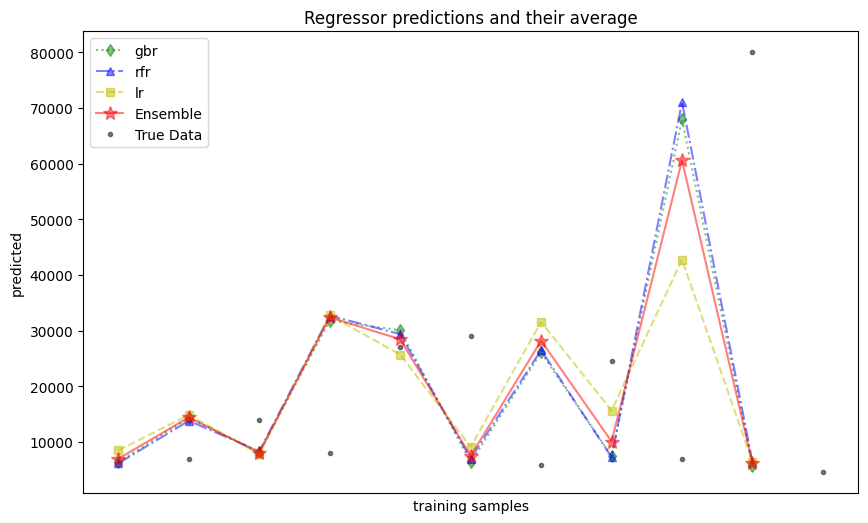

In [73]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(gbr_pred, "gd:", alpha=0.5, label="gbr")
ax.plot(rfr_pred, "b^-.", alpha=0.5, label="rfr")
ax.plot(lr_pred, "ys--", alpha=0.5, label="lr")
ax.plot(ens_pred, "r*-", alpha=0.5, ms=10, label="Ensemble")
ax.plot(yt, "ko", alpha=0.5, ms=3, label="True Data")

ax.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
ax.set_ylabel("predicted")
ax.set_xlabel("training samples")
ax.legend(loc="best")
ax.set_title("Regressor predictions and their average");

In [74]:
mse_scores_train = []
r2_scores_train = []

for model in my_models:

    y_pred_train = model.predict(X_train)

    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_scores_train.append(mse_train)

    r2_train = r2_score(y_train, y_pred_train)
    r2_scores_train.append(r2_train)

mse_scores_test = []
r2_scores_test = []

for model in my_models:

    y_pred_test = model.predict(X_test)

    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_scores_test.append(mse_test)

    r2_test = r2_score(y_test, y_pred_test)
    r2_scores_test.append(r2_test)

ensemble_predictions_train = np.mean([model.predict(X_train) for model in my_models], axis=0)
ensemble_mse_train = mean_squared_error(y_train, ensemble_predictions_train)
ensemble_r2_train = r2_score(y_train, ensemble_predictions_train)

ensemble_predictions_test = np.mean([model.predict(X_test) for model in my_models], axis=0)
ensemble_mse_test = mean_squared_error(y_test, ensemble_predictions_test)
ensemble_r2_test = r2_score(y_test, ensemble_predictions_test)

model_names = ['gbr', 'rf', 'lr']

for i, model in enumerate(my_models):
    print(f"{model_names[i]}:")
    print(f"Train Data - MSE: {mse_scores_train[i]}, R2 score: {r2_scores_train[i]}")
    print(f"Test Data - MSE: {mse_scores_test[i]}, R2 score: {r2_scores_test[i]}")
    print()

print("Ensemble:")
print(f"Train Data - MSE: {ensemble_mse_train}, R2 score: {ensemble_r2_train}")
print(f"Test Data - MSE: {ensemble_mse_test}, R2 score: {ensemble_r2_test}")


gbr:
Train Data - MSE: 6094073.6565770665, R2 score: 0.9496347371584696
Test Data - MSE: 7203913.820609872, R2 score: 0.9388355867576704

rf:
Train Data - MSE: 9707580.15981487, R2 score: 0.9197704435723998
Test Data - MSE: 10381158.93938511, R2 score: 0.9118593710149214

lr:
Train Data - MSE: 27438959.967460494, R2 score: 0.7732271533397239
Test Data - MSE: 27231907.777475815, R2 score: 0.7687890635346982

Ensemble:
Train Data - MSE: 10296780.29368153, R2 score: 0.9149009225786008
Test Data - MSE: 10887326.598175248, R2 score: 0.9075617838112031


#Fine tuning each model using Randomized Search




In [75]:
!pip install --upgrade scikit-learn
from sklearn.model_selection import RandomizedSearchCV


randomized search for Gradient Boosting

In [76]:
gbr_params = {
    'regr__n_estimators': [50, 100, 200],
    'regr__learning_rate': [0.05, 0.1],
    'regr__max_depth': [3, 8],
}
gbr_rand =RandomizedSearchCV(gbr, gbr_params, n_iter=10, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, random_state=42)

gbr_rand.fit(X_train, y_train)
best_gbr_estimator = gbr_rand.best_estimator_

In [77]:
gbr_eval_results = cross_validate(best_gbr_estimator, X_train, y_train, cv=3,
                                  scoring='neg_mean_absolute_error', return_train_score=True)

print("Gradient Boosting Regressor:")
print("Test Mean MAE:", -gbr_eval_results['test_score'].mean())
print("Test Standard Deviation MAE:", gbr_eval_results['test_score'].std())
print("Train Mean MAE:", -gbr_eval_results['train_score'].mean())
print("Train Standard Deviation MAE:", gbr_eval_results['train_score'].std())

Gradient Boosting Regressor:
Test Mean MAE: 1562.1948264252615
Test Standard Deviation MAE: 3.694969162543514
Train Mean MAE: 1424.7388274820594
Train Standard Deviation MAE: 3.9806928002047863


Randomized search for Random forest

In [78]:
rfr_params = {
    'regr__n_estimators': [50, 100, 150],
    'regr__max_depth': [10, 12],
    'regr__max_features': ['auto', 'sqrt', 'log2'],
}


rfr_rand = RandomizedSearchCV(rfr, rfr_params, n_iter=10, cv=3, scoring= 'neg_mean_absolute_error', n_jobs=-1, random_state=42)

rfr_rand.fit(X_train, y_train)
best_rfr_estimator = rfr_rand.best_estimator_


In [ ]:
print("Best parameters:", rfr_rand.best_params_)

Best parameters: {'regr__n_estimators': 100, 'regr__max_features': 'log2', 'regr__max_depth': 12}


In [79]:
rfr_eval_results = cross_validate(best_rfr_estimator, X_train, y_train, cv=3,
                                  scoring='neg_mean_absolute_error', return_train_score=True)

print("Random Forest Regressor:")
print("Test Mean MAE:", -rfr_eval_results['test_score'].mean())
print("Test Standard Deviation MAE:", rfr_eval_results['test_score'].std())
print("Train Mean MAE:", -rfr_eval_results['train_score'].mean())
print("Train Standard Deviation MAE:", rfr_eval_results['train_score'].std())


Random Forest Regressor:
Test Mean MAE: 1799.0776926080505
Test Standard Deviation MAE: 3.351156357330622
Train Mean MAE: 1706.731244988092
Train Standard Deviation MAE: 1.4136159936709285


In [80]:
lr_params = {
    'pp__num__poly__degree': [2, 3, 5],
}

lr_rand = RandomizedSearchCV(lr, lr_params, n_iter=20, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, random_state=42)

lr_rand.fit(X_train, y_train)
best_lr_estimator = lr_rand.best_estimator_


In [81]:
lr_eval_results = cross_validate(best_lr_estimator, X_train, y_train, cv=3,
                                 scoring='neg_mean_absolute_error', return_train_score=True)

print("Linear Regression:")
print("Test Mean MAE:", -lr_eval_results['test_score'].mean())
print("Test Standard Deviation MAE:", lr_eval_results['test_score'].std())
print("Train Mean MAE:", -lr_eval_results['train_score'].mean())
print("Train Standard Deviation MAE:", lr_eval_results['train_score'].std())


Linear Regression:
Test Mean MAE: 3369.4187313766543
Test Standard Deviation MAE: 6.862384948155483
Train Mean MAE: 3369.313957223914
Train Standard Deviation MAE: 2.8821239169660413


In [82]:
ensemble_tuned = VotingRegressor([('gbr', best_gbr_estimator), ('rfr', best_rfr_estimator), ('lr', best_lr_estimator)])

ensemble_tuned.fit(X_train, y_train)

VotingRegressor(estimators=[('gbr',
                             Pipeline(steps=[('pp',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer())]),
                                                                               ['mileage',
                                                                                'vehicle_age',
                                                                                'standard_colour',
                                                                                'standard_make',
                                                                                'standard_model',
                                                                                'vehicle_condition',
                                                                                'body_type',
                                                                                'fuel_type']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most...
                                                                               ['mileage',
                                                                                'vehicle_age',
                                                                                'standard_colour',
                                                                                'standard_make',
                                                                                'standard_model',
                                                                                'vehicle_condition',
                                                                                'body_type',
                                                                                'fuel_type']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent'))]),
                                                                               [])],
                                                                verbose_feature_names_out=False)),
                                             ('feat_sel',
                                              SelectKBest(k=8,
                                                          score_func=<function f_regression at 0x793a3b0c0550>)),
                                             ('regr', LinearRegression())]))])

In [83]:
# Cross-validate the ensemble model
ensemble_eval_results = cross_validate(ensemble_tuned, X_train, y_train, cv=3,
                                      scoring='neg_mean_absolute_error', return_train_score=True)

print("Ensemble of Tuned Models:")
print("Test Mean MAE:", -ensemble_eval_results['test_score'].mean())
print("Test Standard Deviation MAE:", ensemble_eval_results['test_score'].std())
print("Train Mean MAE:", -ensemble_eval_results['train_score'].mean())
print("Train Standard Deviation MAE:", ensemble_eval_results['train_score'].std())


Ensemble of Tuned Models:
Test Mean MAE: 2000.488453133885
Test Standard Deviation MAE: 4.762925339337756
Train Mean MAE: 1939.8148831979381
Train Standard Deviation MAE: 1.6256888050181901


#Global and Local Explanations with SHAP

shap for Gradient Boosting

In [84]:
check_additivity=False

In [85]:
gbr = gbr.named_steps['regr']

In [86]:
explainer = shap.TreeExplainer(gbr, X_train)

In [87]:
shap_values = explainer(X_test, check_additivity=False)

100%|===================| 71931/71988 [10:25<00:00]       

In [88]:
shap_values.values

array([[  735.75117093,   142.31336552,    81.20531292, ...,
            0.        ,  -851.24184693,   342.3790132 ],
       [-1117.52899647, -4312.7850358 ,  -448.70708141, ...,
            0.        ,  -412.30120447,   228.01142387],
       [-3543.34585272, -3960.92318952,  -120.36789983, ...,
            0.        ,   620.84606622,    74.08830444],
       ...,
       [ -941.45531871,  1044.0953121 ,    58.87089409, ...,
            0.        ,   781.72400663,   123.56578397],
       [ 5696.16711583,  3689.99888015,   -53.89661836, ...,
            0.        ,    17.30385018,   -90.59296184],
       [-1766.81271535, -5303.82754002,  -238.69416101, ...,
            0.        ,  -649.13814319,    75.5646188 ]])

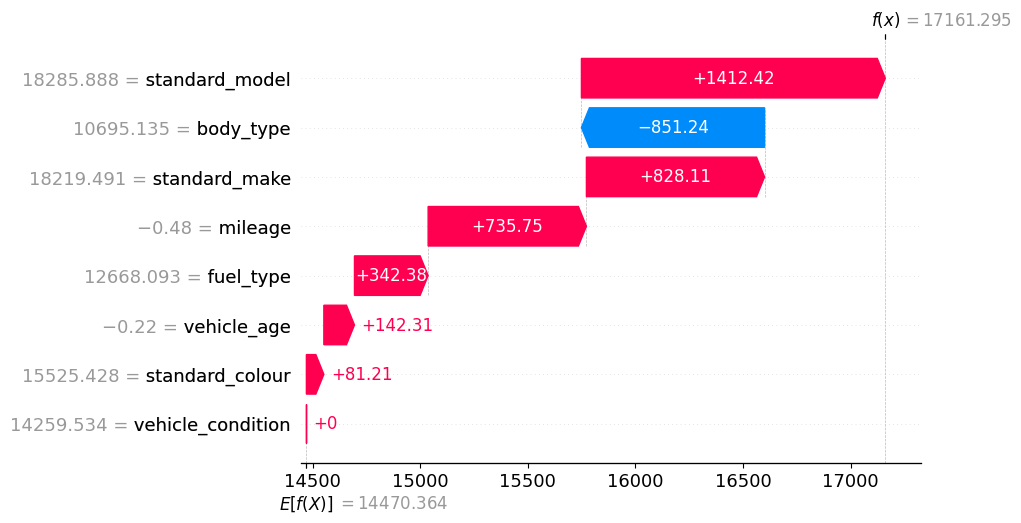

In [89]:
shap.plots.waterfall(shap_values[0])

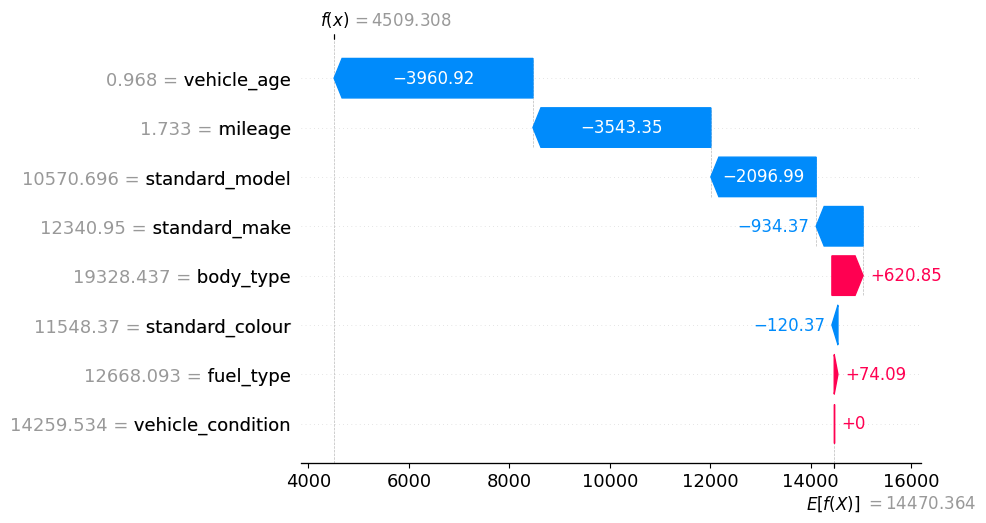

In [90]:
shap.plots.waterfall(shap_values[2])

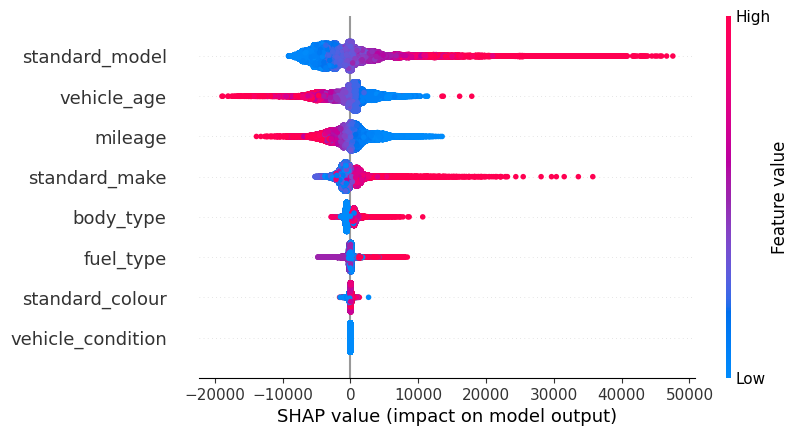

In [91]:
shap.plots.beeswarm(shap_values)

In [ ]:
#coefs = pd.DataFrame({
 #'feature': X.columns,
  #'coefficient': np.round(gbr.named_steps['regr'].feature_importances_, 3)
#})
#coefs

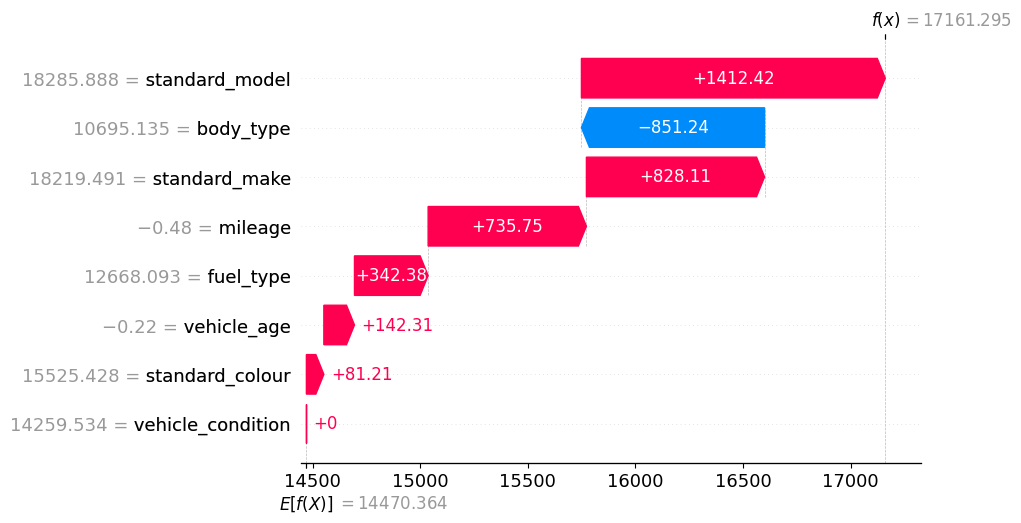

In [92]:
shap.plots.waterfall(shap_values[0])

shap for Random Forest

In [93]:
rfr = rfr.named_steps['regr']

In [94]:
explainer = shap.TreeExplainer(rfr, X_train)

In [95]:
shap_values = explainer(X_test, check_additivity=False)

100%|===================| 71987/71988 [17:43<00:00]       

In [96]:
shap_values.values

array([[ 1.35485938e+03,  9.28155232e+02, -1.02879503e+01, ...,
         0.00000000e+00,  4.96937898e+01,  2.26712288e+02],
       [-5.37271311e+02, -4.82366852e+03, -1.09923520e+01, ...,
         0.00000000e+00, -1.32021363e+02,  2.62454765e+01],
       [-2.85117553e+03, -4.50884743e+03, -1.01064587e+01, ...,
         0.00000000e+00,  4.89458323e+02, -1.65857912e+00],
       ...,
       [-4.56835338e+02,  2.46627016e+02, -6.16086450e-01, ...,
         0.00000000e+00,  2.41862484e+02, -2.25456175e+01],
       [ 1.98364839e+03,  5.28594631e+03,  9.26052402e+00, ...,
         0.00000000e+00,  2.29822035e+02, -7.57500608e+02],
       [-1.20602051e+03, -5.64625629e+03, -2.06225743e+01, ...,
         0.00000000e+00, -4.12334011e+02, -2.80361860e+01]])

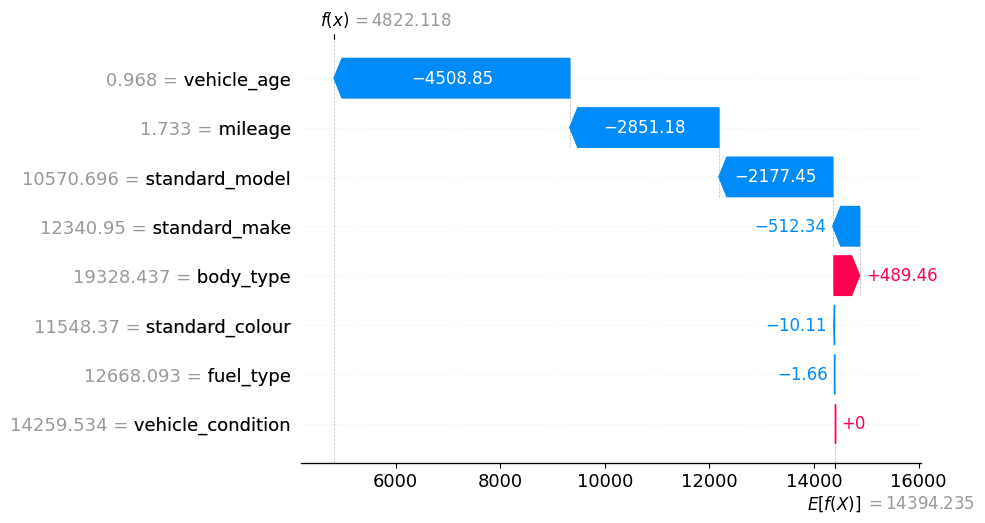

In [97]:
shap.plots.waterfall(shap_values[2])

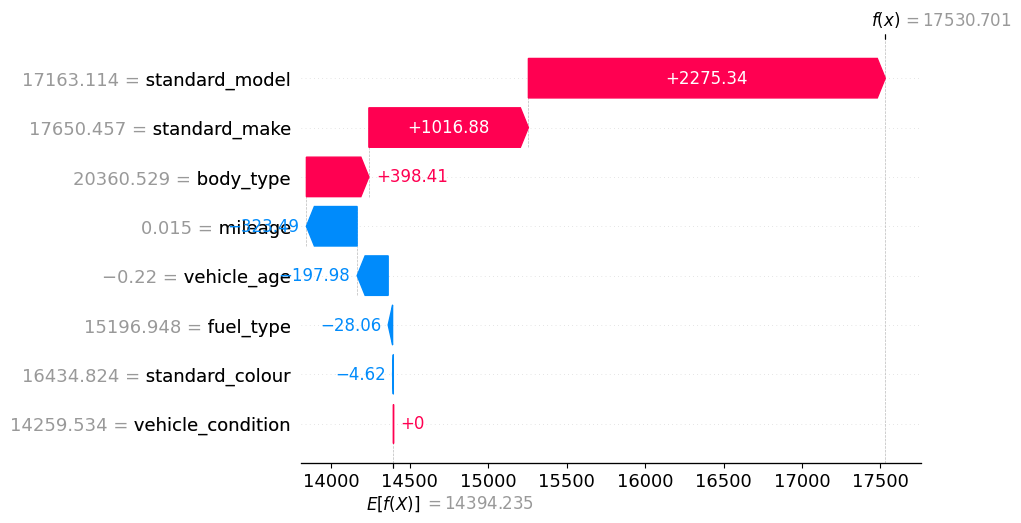

In [98]:
shap.plots.waterfall(shap_values[4])

shap for Linear regressor

In [99]:
lr = lr.named_steps['regr']

In [100]:
coefficients = lr.coef_

coefs = pd.DataFrame({
    'feature': X.columns,
    'coefficient': coefficients
})

print(coefs)


             feature   coefficient
0            mileage -3.101223e+03
1        vehicle_age  1.889175e+03
2    standard_colour  5.855638e+03
3      standard_make  5.621810e+08
4     standard_model -2.996195e+14
5  vehicle_condition -3.394080e-02
6          body_type  3.367250e+02
7          fuel_type  2.334936e-02


In [101]:
coefs = pd.DataFrame({
    'feature': X.columns,
   'coefficient': np.round(lr.coef_, 3)  # Accessing coefficients from the estimator
})
print(coefs)

             feature   coefficient
0            mileage -3.101223e+03
1        vehicle_age  1.889175e+03
2    standard_colour  5.855638e+03
3      standard_make  5.621810e+08
4     standard_model -2.996195e+14
5  vehicle_condition -3.400000e-02
6          body_type  3.367250e+02
7          fuel_type  2.300000e-02


In [102]:
explainer = shap.LinearExplainer(lr, X_train)

In [103]:
shap_values = explainer(X_test)

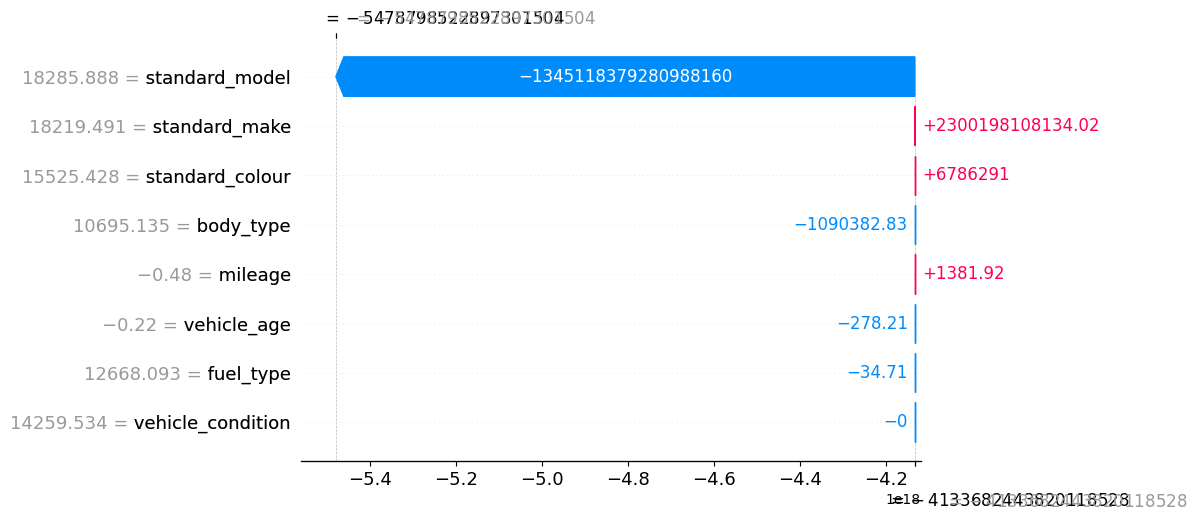

In [104]:
shap.plots.waterfall(shap_values[0])

In [105]:
coefs = pd.DataFrame({
  'feature': X.columns,
  'coefficient': np.round(lr.coef_, 3)
})
coefs

feature   coefficient
0            mileage -3.101223e+03
1        vehicle_age  1.889175e+03
2    standard_colour  5.855638e+03
3      standard_make  5.621810e+08
4     standard_model -2.996195e+14
5  vehicle_condition -3.400000e-02
6          body_type  3.367250e+02
7          fuel_type  2.300000e-02

#Partial Dependency Plots

In [106]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

Gradient boosting

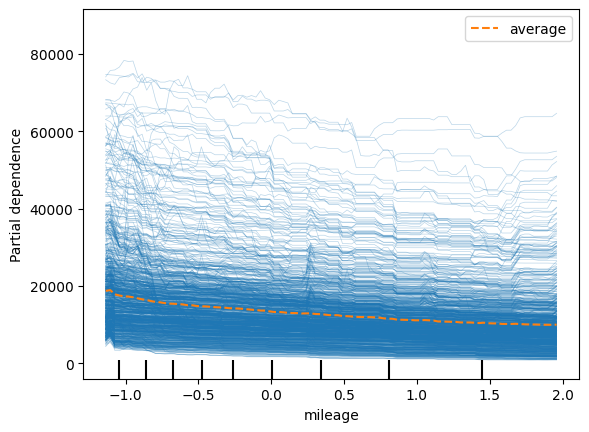

In [107]:
PartialDependenceDisplay.from_estimator(
    gbr, X_test, features=['mileage'], kind='both'
);

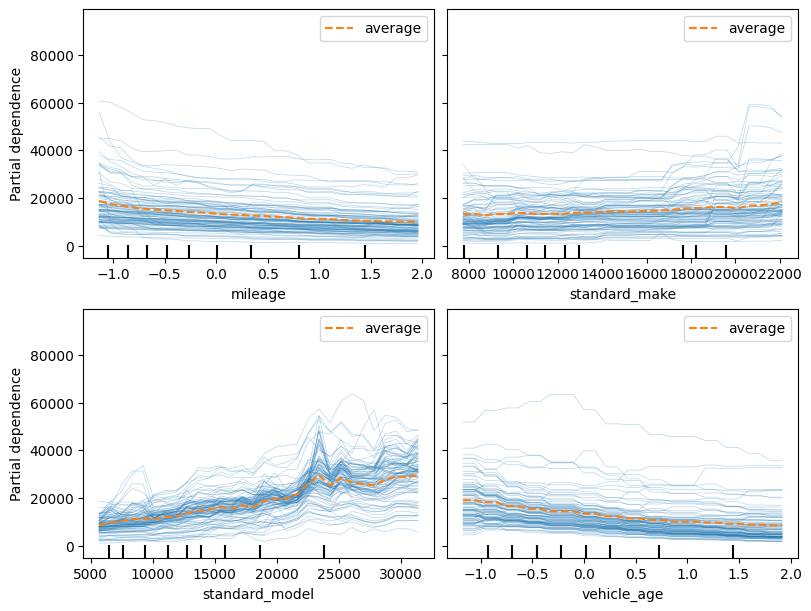

In [108]:
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    gbr, X_test, features=['mileage', 'standard_make', 'standard_model', 'vehicle_age'],
    kind='both',
    subsample=100, grid_resolution=30, n_jobs=2, random_state=0,
    ax=ax, n_cols=2
);

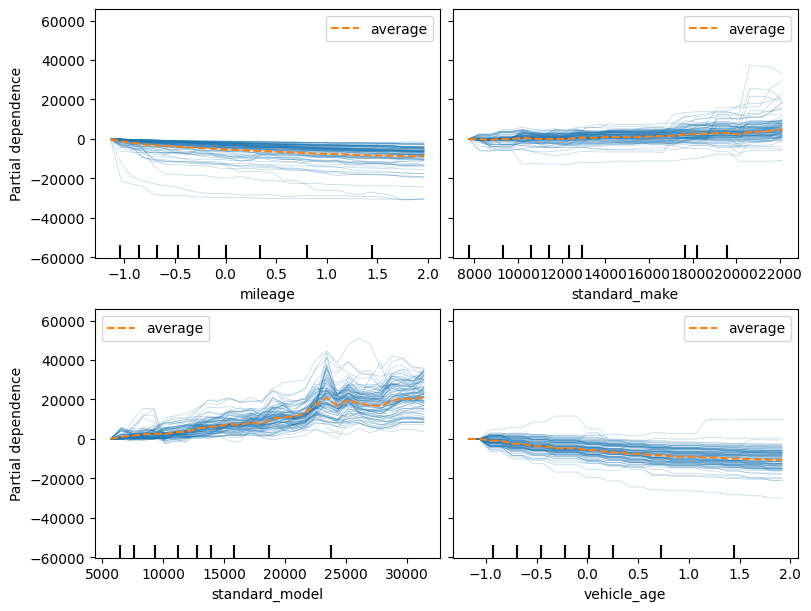

In [109]:
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    gbr, X_test, features=['mileage', 'standard_make', 'standard_model', 'vehicle_age'],
    kind='both', centered=True,
    subsample=100, grid_resolution=30, n_jobs=2, random_state=0,
    ax=ax, n_cols=2
);

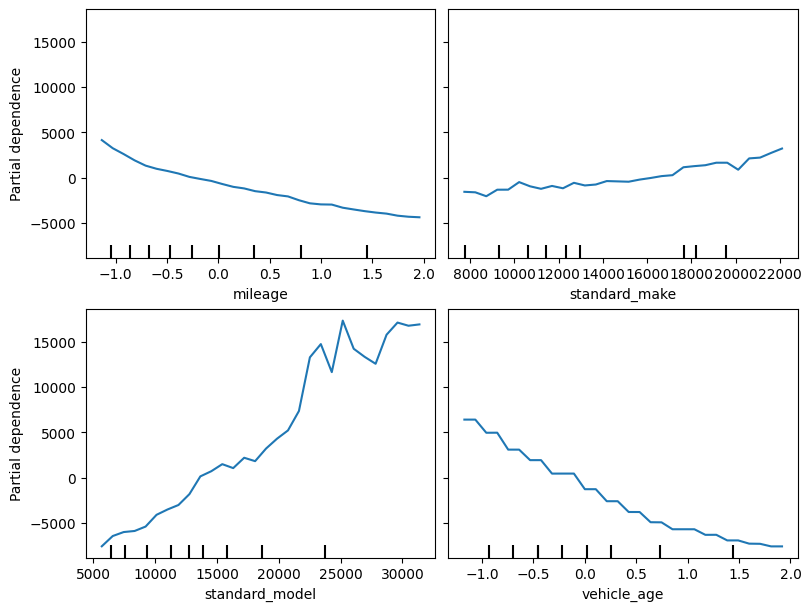

In [110]:
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    gbr, X_test, features=['mileage', 'standard_make', 'standard_model', 'vehicle_age'],
    kind='average',
    subsample=100, grid_resolution=30, n_jobs=2, random_state=0,
    ax=ax, n_cols=2
);

Random Forest

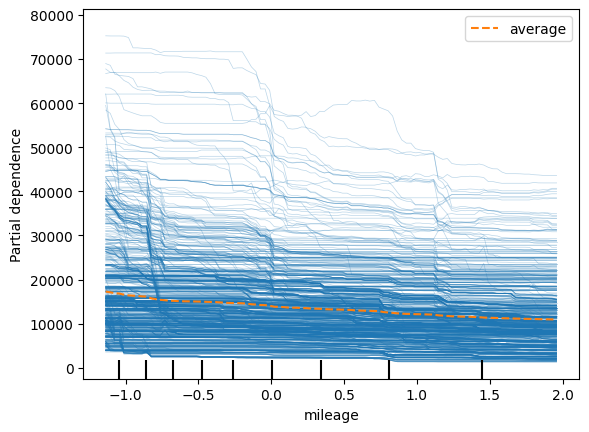

In [111]:
PartialDependenceDisplay.from_estimator(
    rfr, X_test, features=['mileage'], kind='both'
);

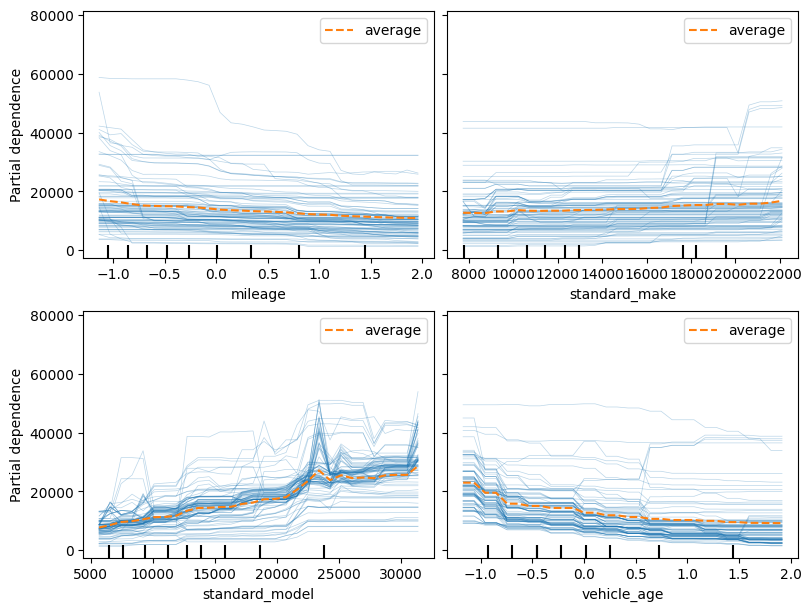

In [112]:
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    rfr, X_test, features=['mileage', 'standard_make', 'standard_model', 'vehicle_age'],
    kind='both',
    subsample=100, grid_resolution=30, n_jobs=2, random_state=0,
    ax=ax, n_cols=2
);

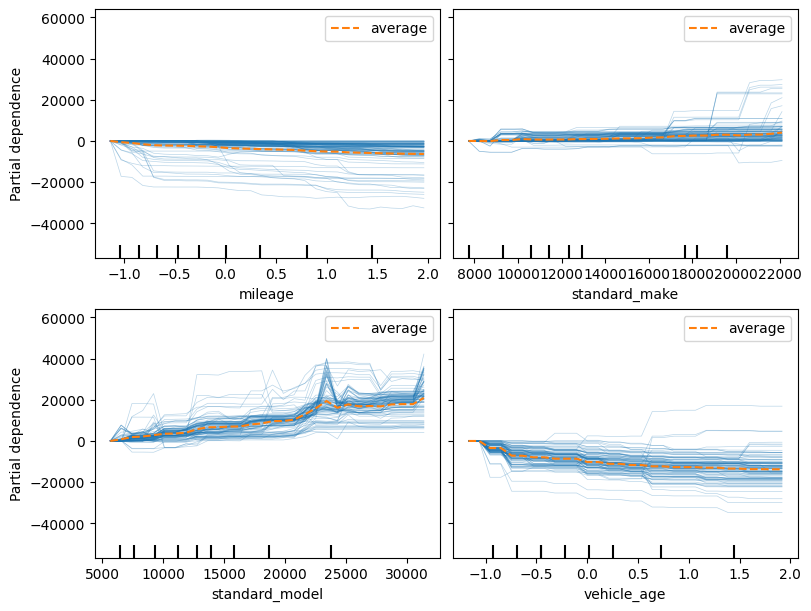

In [113]:
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    rfr, X_test, features=['mileage', 'standard_make', 'standard_model', 'vehicle_age'],
    kind='both', centered=True,
    subsample=100, grid_resolution=30, n_jobs=2, random_state=0,
    ax=ax, n_cols=2
);

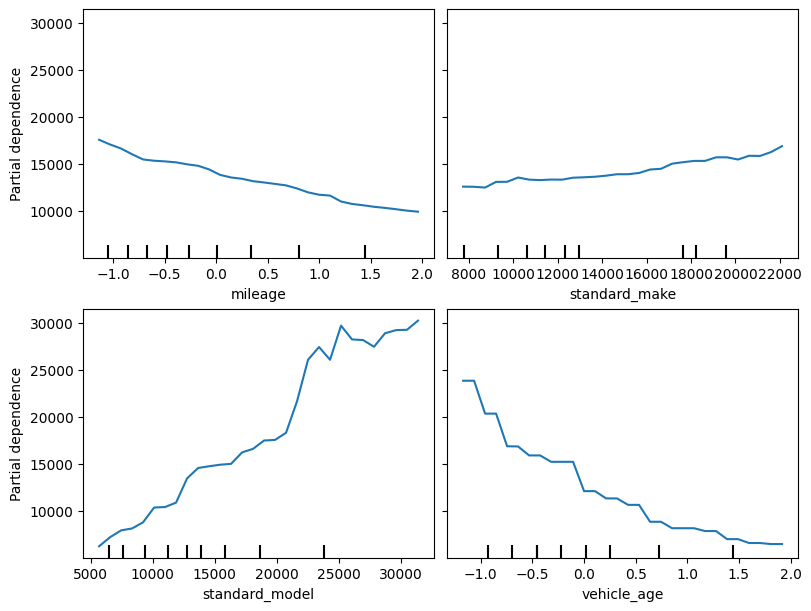

In [114]:
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    rfr, X_test, features=['mileage', 'standard_make', 'standard_model', 'vehicle_age'],
    kind='average',
    subsample=100, grid_resolution=30, n_jobs=2, random_state=0,
    ax=ax, n_cols=2
);

linear

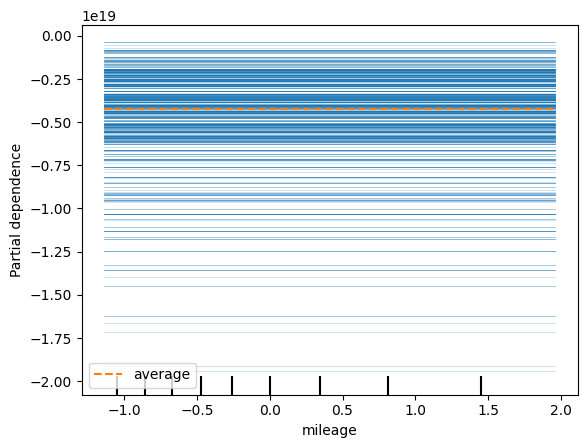

In [115]:
PartialDependenceDisplay.from_estimator(
    lr, X_test, features=['mileage'], kind='both'
);

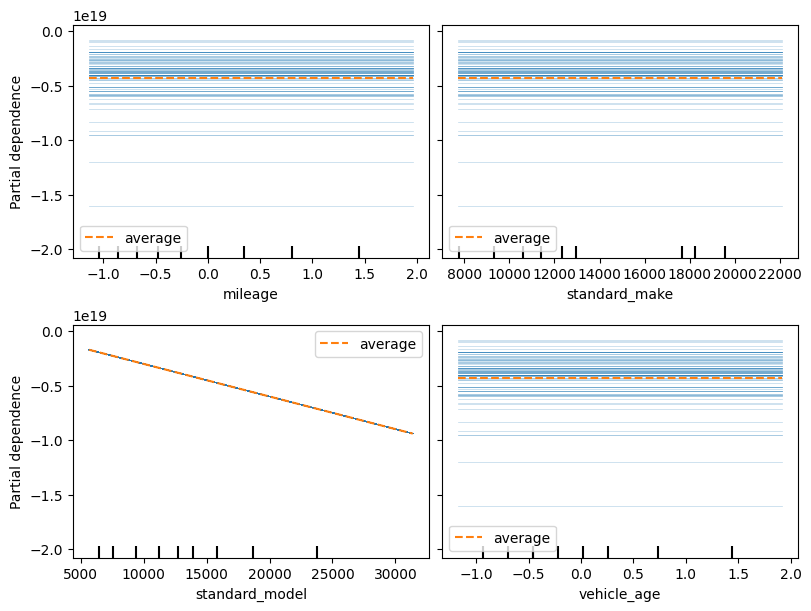

In [116]:
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    lr, X_test, features=['mileage', 'standard_make', 'standard_model', 'vehicle_age'],
    kind='both',
    subsample=100, grid_resolution=30, n_jobs=2, random_state=0,
    ax=ax, n_cols=2
);

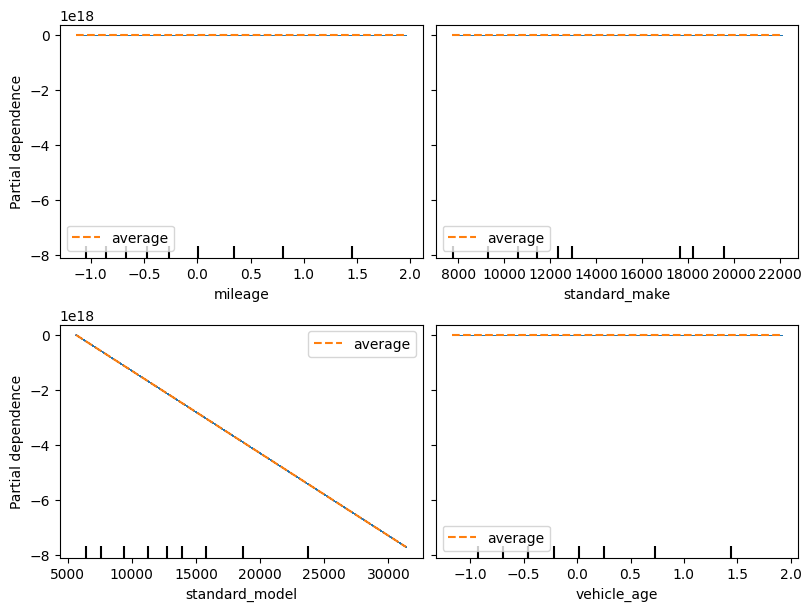

In [117]:
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    lr, X_test, features=['mileage', 'standard_make', 'standard_model', 'vehicle_age'],
    kind='both', centered=True,
    subsample=100, grid_resolution=30, n_jobs=2, random_state=0,
    ax=ax, n_cols=2
);

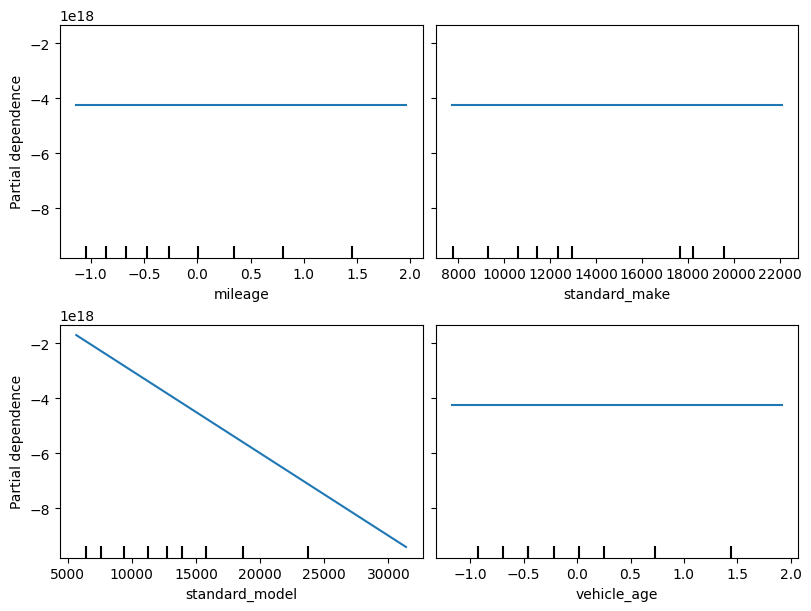

In [118]:
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    lr, X_test, features=['mileage', 'standard_make', 'standard_model', 'vehicle_age'],
    kind='average',
    subsample=100, grid_resolution=30, n_jobs=2, random_state=0,
    ax=ax, n_cols=2
);

ensemble

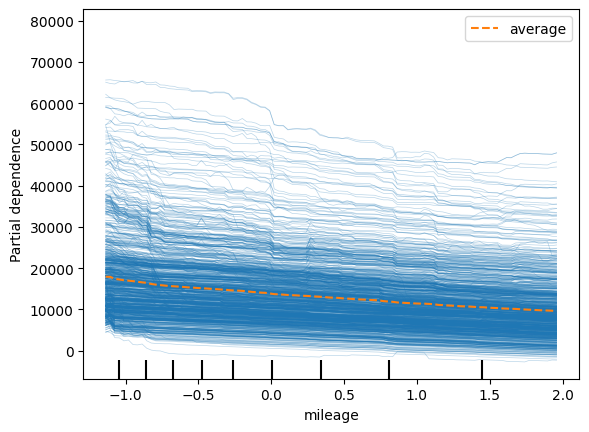

In [119]:
PartialDependenceDisplay.from_estimator(
    ensemble, X_test, features=['mileage'], kind='both'
);

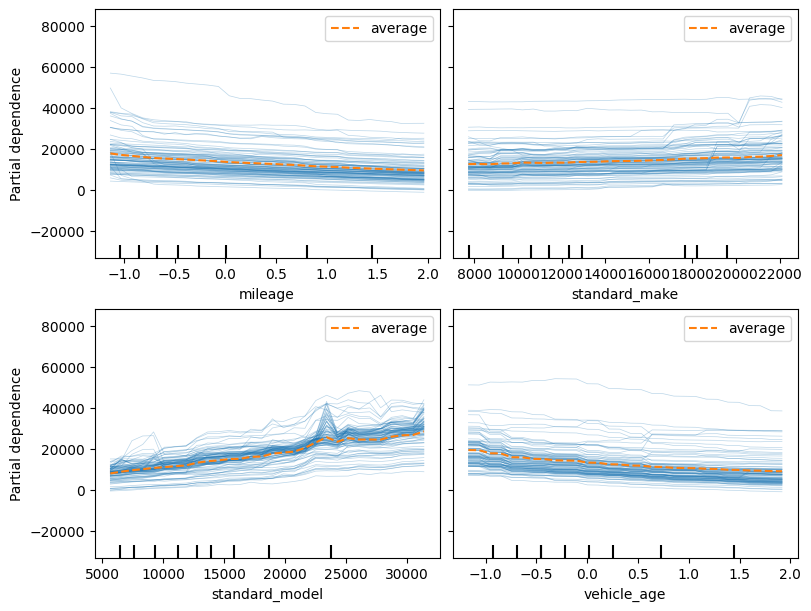

In [120]:
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    ensemble, X_test, features=['mileage', 'standard_make', 'standard_model', 'vehicle_age'],
    kind='both',
    subsample=100, grid_resolution=30, n_jobs=2, random_state=0,
    ax=ax, n_cols=2
);

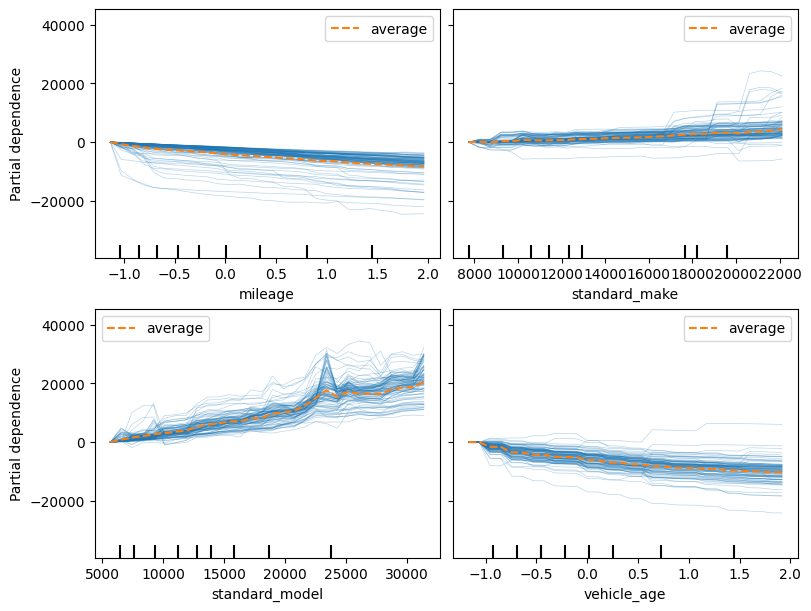

In [121]:
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    ensemble, X_test, features=['mileage', 'standard_make', 'standard_model', 'vehicle_age'],
    kind='both', centered=True,
    subsample=100, grid_resolution=30, n_jobs=2, random_state=0,
    ax=ax, n_cols=2
);

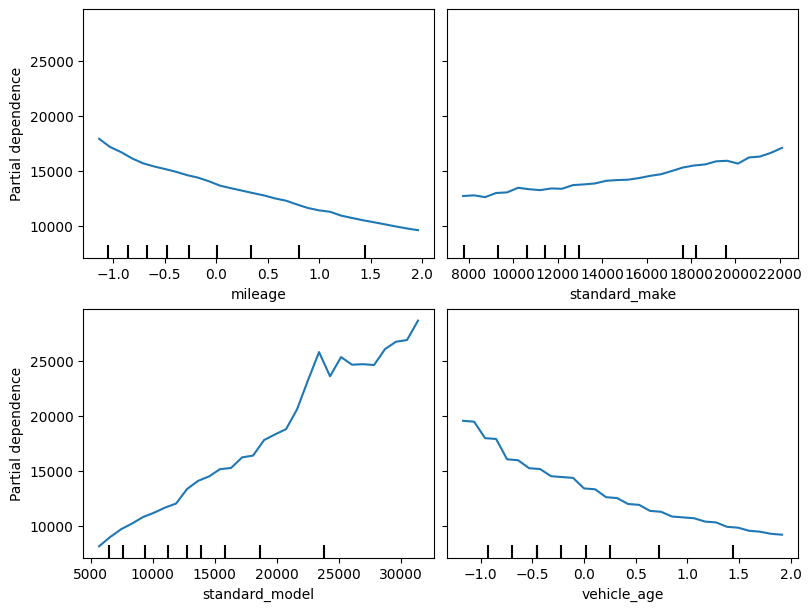

In [122]:
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    ensemble, X_test, features=['mileage', 'standard_make', 'standard_model', 'vehicle_age'],
    kind='average',
    subsample=100, grid_resolution=30, n_jobs=2, random_state=0,
    ax=ax, n_cols=2
);

#Feature Importance

In [125]:
feature_importance = pd.Series(gbr.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print(feature_importance)


standard_model       0.596202
vehicle_age          0.217930
mileage              0.112026
standard_make        0.049205
fuel_type            0.013348
body_type            0.010189
standard_colour      0.001100
vehicle_condition    0.000000
dtype: float64


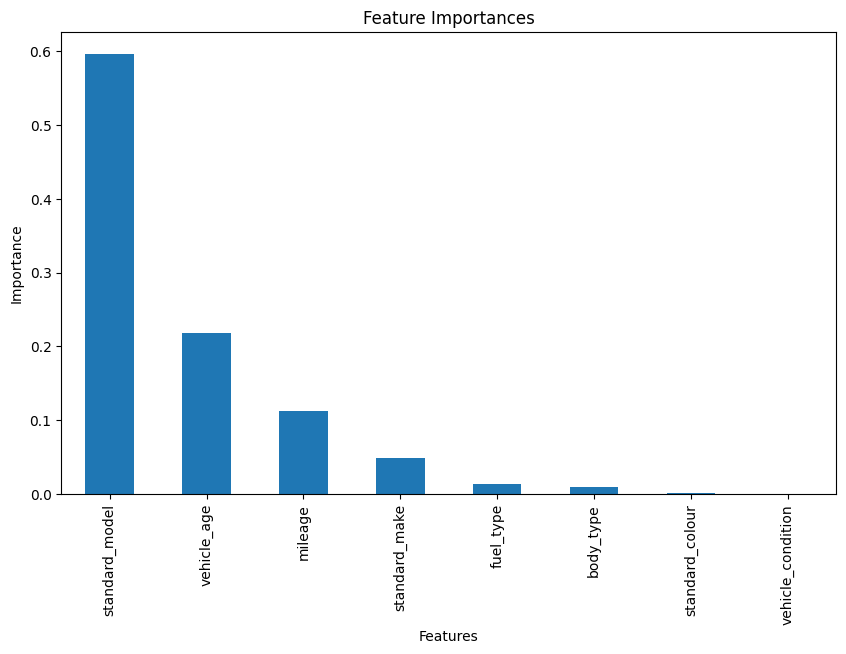

In [127]:
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()